## Crop/select aera and calculate cloud fraction should be done in the same period.

In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline
import datetime
from netCDF4 import Dataset # used for the netcdf files which contain lat, lon.
import seaborn as sns

In [4]:
path      = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_data_raw/'
path_era  = '//uio/lagringshotell/geofag/students/metos/hannasv/era_interim_data/'
nc_path   = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_coordinates/'

nc_files  = glob.glob(nc_path + '*.nc')
grb_files = glob.glob(path+"*.grb")
era = glob.glob(path_era+"*q.nc")

In [5]:
grb_file = grb_files[0]
era_file = era[0]
nc_file = nc_files[0]

data = xr.open_dataset(grb_file, engine = "pynio")
era = xr.open_dataset(era_file)

In [6]:
def timestamp(filename):
    """
    Returns the np.datetime64 [ns] for the current date.
    """
    splits = filename.split('-')
    # print(splits)
    ts = splits[5]
    year = ts[:4]
    month = ts[4:6]
    day = ts[6:8]
    hr = ts[8:10]
    minuts = ts[10:12]
    sek = ts[12:14]
    return np.datetime64( year+"-"+month+"-"+day+"T"+hr+":"+minuts+":"+sek )

## Retrieving coordinates from nc file. 
### Notes a nc is 10 times as large as a grib file that is why we only have one of them

In [7]:
ts = timestamp(grb_file)
data['time'] = ts
# Add time as a coordinate and dimension. 
data = data.assign_coords(time = data.time)
cmk = data['CLOUDM_P30_GSV0_I207'].values

['//uio/lagringshotell/geofag/students/metos/hannasv/satelite_data_raw/MSG3', 'SEVI', 'MSGCLMK', '0100', '0100', '20131013120000X20131013121500.000000000Z', '20131013122758', '1340656.grb']


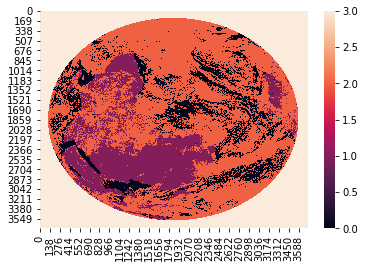

In [8]:
# as a reference that its upside down --> explain negative latitude values.
# 3 -off earth disk
# 2 - cloud
# 1 - not cloud over ocean and 0 not cloud over land

sns.heatmap(data['CLOUDM_P30_GSV0_I207'].values)

In [24]:
def fix_one_sat_file(filename):
    """
    filename : str
        full absoulute path to file.
    
    This reads a raw satelite file.
    Add time, longitude, latitude.
    """
    data = xr.open_dataset(filename, engine="pynio")

    ts = timestamp(filename)
    data['time'] = ts
    
    # Add time as a coordinate and dimension. 
    data = data.assign_coords(time = data.time)
    data = data.expand_dims(dim = 'time')
        
    # Rename dimenstions and coordinates 
    data = data.rename(name_dict={'xgrid_0': 'longitude', 
                                  'ygrid_0':'latitude', 
                                  'CLOUDM_P30_GSV0_I207':'tcc'}, inplace=True)
    # crop to correct region 
    # data = data.sel(latitude = slice(30,60))
    # data = data.sel(longitude = slice(-15, 42))

    tcc, counting = calc_all(data.tcc.values)
    
    data['tcc'].values = tcc
    data['xgrid_0'] = np.arange(-15, 42+0.75, 0.75)
    data['ygrid_0'] = np.arange(30, 60+0.75, 0.75)
    
    return data

# Get data from file with coordinates

In [309]:
rootgrp = Dataset(nc_file, "r", format="NETCDF4")
cloud_mask_array = rootgrp.variables["cloudMask"][:].data
lat_array = rootgrp.variables["lat"][:].data
lon_array = rootgrp.variables["lon"][:].data
lat_array[lat_array < -99] = np.nan # updates of disk values to nan
lon_array[lon_array < -99] = np.nan # updates of disk values to nan

# OBS! Data in grb files needs to be flipped left right to be coherant with netCDF files ..

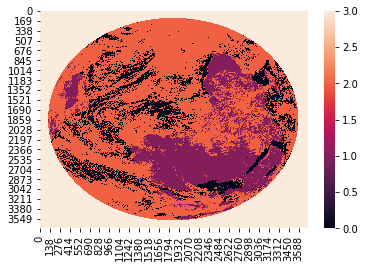

In [15]:
sns.heatmap(np.fliplr(data['CLOUDM_P30_GSV0_I207'].values))

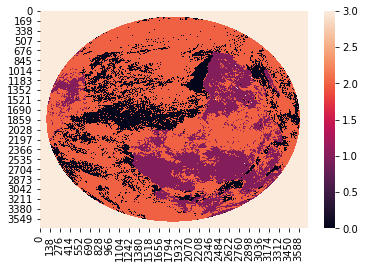

In [12]:
sns.heatmap(cloud_mask_array)

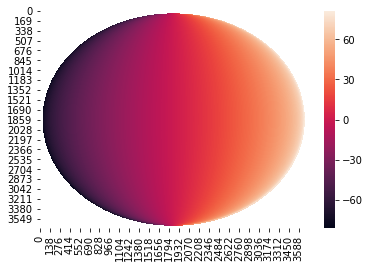

In [23]:
sns.heatmap(lon_array)

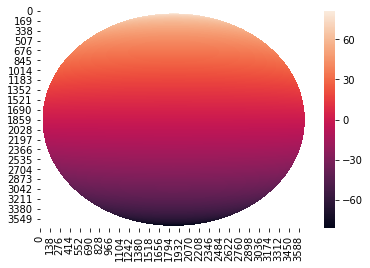

In [25]:
sns.heatmap(np.flipud(lat_array))

In [58]:
lat_array = np.flipud(lat_array)

# Må hente ut rader og transponere dem for at du skal kunne vektorisere trekke fra elementet i under i samme kolonne.

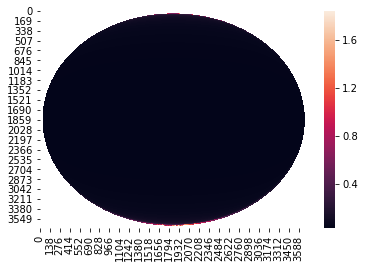

In [63]:
d_theta = (lat_array[1:, :].transpose() - lat_array[:-1, :].transpose() ).transpose() 
sns.heatmap(d_theta)

# Compute the d_phi and d_theta

In [81]:
d_phi   = lon_array[:, 1:] - lon_array[:, :-1]
d_theta = lat_array[1:] - lat_array[:-1]

In [86]:
pad     = np.ones((3712, 1))*np.nan # adding numpy to the axis the values 
d_phi   = np.concatenate((pad, d_phi), axis = 1)/2
d_theta = np.concatenate((pad.transpose(), d_theta), axis = 0)/2

# HVA BETYR DET EGENTLIG AT DENNE PADDES FORRAN.
## dET BETYR at y-x blir d_phi i punktet y.

[x, y
.., ..
.., ..
.., ..]

In [340]:
def area_grid_cell(c_lat, d_lat, d_lon):
    """
    c_lon, c_lat : float
        Centre point longitude, latitude in degrees
    d_lat, d_lon : float
        delta lat lon in degrees
        
    Returns : area in km^2
    
    cdo : If the grid cell area have to be computed it is scaled with the earth radius to square meters.
    """   
    R = 6371000  # in M
    # area er egentlig R**2
    area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
    return area

In [341]:
area_grid_cell(era.latitude.values, 0.375, 0.375)

array([282.54030483, 296.31439323, 310.04374443, 323.71841682,
       337.3384104 , 350.89875437, 364.39944874, 377.8355227 ,
       391.21194706, 404.5138094 , 417.75602214, 430.91870207,
       444.01179079, 457.03031751, 469.96931141, 482.8188309 ,
       495.59875919, 508.28921306, 520.88522173, 533.40169758,
       545.81875742, 558.15628446, 570.38445388, 582.51320729,
       594.55745709, 606.48240767, 618.31291305, 630.03903161,
       641.65579256, 653.1582251 , 664.55130002, 675.83501733,
       686.98949383, 698.04455431, 708.96540318, 719.77192364,
       730.45417408, 741.01215451, 751.44089412, 761.73542211,
       771.9106509 , 781.94669726, 791.85350281, 801.62112595,
       811.24956667, 820.74379577, 830.09387166, 839.30476513,
       848.36653458, 857.28912162, 866.05761384, 874.68692364,
       883.15716782, 891.48822959, 899.65028414, 907.67315627,
       915.53199198, 923.23176208, 930.78240816, 938.16404701,
       945.39407645])

# Comparing to ERA cdo gridarea calculated area 

# R*area = true/R

In [342]:
#(era.cell_area.values/6371000)[:,0] # now it should be similar to the area without dividing on R**2

# Fortsett her in the morning...

In [343]:
# Make this a loop over lat_lons?
lat_bondaries = np.array([[-15],
                          [30]])

BOUND =  np.array([[-0.75/2, 0.75/2],
                   [-0.75/2, 0.75/2]])

ranges = lat_bondaries + BOUND

In [344]:
lat_bondaries + BOUND

array([[-15.375, -14.625],
       [ 29.625,  30.375]])

In [345]:
lon_range = ranges[0, :]
lat_range = ranges[1, :]
min_lon, max_lon = lon_range
min_lat, max_lat = lat_range

In [354]:
d_phi   = d_phi.reshape(-1)
d_theta = d_theta.reshape(-1)

In [369]:
ranges[1,0], ranges[1,1]

(29.625, 30.375)

* up_cmk - era_down > 0 

* down_cmk - era_up < 0
* left_cmk - era_right < 0
* right_cmk - era_left > 0

Alle indexer he skal være med..?

In [379]:
ranges

array([[-15.375, -14.625],
       [ 29.625,  30.375]])

In [390]:
era_up    = ranges[1, 1]
era_down  = ranges[1, 0]
era_left  = ranges[0, 0]
era_right = ranges[0, 1]

In [391]:
era_up, era_down, era_left, era_right

(30.375, 29.625, -15.375, -14.625)

In [415]:
c_lon = lon_array.reshape(-1) #+ d_phi
c_lat = lat_array.reshape(-1) #+ d_theta

cmk_left  = c_lon - d_phi   #- era_right
cmk_right = c_lon + d_phi   #- era_left
cmk_up    = c_lat + d_theta #- era_down
cmk_down  = c_lat - d_theta #- era_up

In [420]:
diff_l    = np.argwhere(cmk_right - era_left < 0.375)
diff_r    = np.argwhere(era_right - cmk_left < 0.375)
diff_down = np.argwhere(cmk_up - era_down < 0.375)
diff_up   = np.argwhere(era_up - cmk_down < 0.375)
#cmk_right = c_lon + d_phi   #- era_left
#cmk_up    = c_lat + d_theta #- era_down
#cmk_down  = c_lat - d_theta #- era_up

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


# IF this doesn't work use lat lon to restrict even further???

In [418]:
(diff_l).sum(), (diff_r).sum(), (diff_).sum(), 

(2078083, 8135330)

In [407]:
one   = np.argwhere(left  < 0) 
two   = np.argwhere(right > 0) 
three = np.argwhere(up    > 0) 
four  = np.argwhere(down  < 0) 

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [423]:
one = diff_l
two = diff_r

three = diff_up
four = diff_down

In [424]:
len(np.intersect1d(one, two))

0

In [425]:
len(np.intersect1d(one, three))

23674

In [426]:
len(np.intersect1d(one, four))

2050697

In [427]:
len(np.intersect1d(three, two))

114374

In [428]:
len(np.intersect1d(four, two))

8005880

In [429]:
len(np.intersect1d(three, four))

0

In [430]:
len(one), len(two), len(three), len(four)

(2078083, 8135330, 139184, 10121662)

# Fortsett her

In [347]:
low     = np.argwhere(c_lon < min_lon) 
upper   = np.argwhere(c_lon < max_lon)
idx_phi = np.intersect1d(low, upper)

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [154]:
low   = np.argwhere(c_lat > min_lat) 
upper = np.argwhere(c_lat < max_lat)
idx_theta = np.intersect1d(low, upper)

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


# Need to allow centre to be outside the era cell but some parts of the cell inside it 

In [349]:
idx_final = np.intersect1d(idx_phi, idx_theta)
c_lon = c_lon[idx_final]
c_lat = c_lat[idx_final]

In [351]:
c_lon, c_lat

(array([-15.366567 , -15.332924 , -15.299291 , -15.265666 , -15.232051 ,
        -15.198444 , -15.164847 , -15.131259 , -15.09768  , -15.06411  ,
        -15.030548 , -14.996996 , -14.963452 , -14.929918 , -14.896393 ,
        -14.862876 , -14.829368 , -14.795868 , -14.762378 , -14.728895 ,
        -14.695422 , -14.661958 , -14.628502 , -15.372708 , -15.33905  ,
        -15.305402 , -15.271763 , -15.238132 , -15.204512 , -15.1709   ,
        -15.137297 , -15.1037035, -15.070118 , -15.036543 , -15.002975 ,
        -14.969418 , -14.935868 , -14.902328 , -14.868796 , -14.835274 ,
        -14.80176  , -14.768254 , -14.734758 , -14.70127  , -14.667791 ,
        -14.634321 , -15.345191 , -15.311528 , -15.277874 , -15.244229 ,
        -15.210593 , -15.176967 , -15.143349 , -15.10974  , -15.076141 ,
        -15.04255  , -15.008968 , -14.975396 , -14.941832 , -14.908277 ,
        -14.874731 , -14.841193 , -14.807665 , -14.774145 , -14.740634 ,
        -14.707131 , -14.673638 , -14.640153 , -15.

In [171]:
min(lon_array.reshape(-1)[idx_final] - d_phi.reshape(-1)[idx_final])

-15.390471458435059

In [172]:
max(lon_array.reshape(-1)[idx_final] + d_phi.reshape(-1)[idx_final])

-14.609238624572754

In [169]:
min(lat_array.reshape(-1)[idx_final])

29.633375

In [175]:
min(lat_array.reshape(-1)[idx_final] - d_phi.reshape(-1)[idx_final])

29.616647243499756

In [174]:
max(lat_array.reshape(-1)[idx_final] + d_phi.reshape(-1)[idx_final])

30.38490343093872

In [168]:
lon_range, lat_range

(array([-15.375, -14.625]), array([29.625, 30.375]))

In [186]:
idx_left_bound = np.argwhere(lon_array.reshape(-1)[idx_final] - d_phi.reshape(-1)[idx_final] < min_lon) 

In [194]:
idx_right_bound = np.argwhere(lon_array.reshape(-1)[idx_final] + d_phi.reshape(-1)[idx_final] > max_lon);
# Hvorfor er denne så lang .. 

In [195]:
idx_lower_bound = np.argwhere(lat_array.reshape(-1)[idx_final] - d_theta.reshape(-1)[idx_final] < min_lat) 

In [196]:
idx_upper_bound = np.argwhere(lat_array.reshape(-1)[idx_final] + d_theta.reshape(-1)[idx_final] > max_lat) 

# Boundaries are on all edges.

In [197]:
len(idx_left_bound), len(idx_right_bound), len(idx_lower_bound), len(idx_upper_bound), len(idx_final)

(11, 11, 10, 11, 490)

In [202]:
idx_bounds = np.concatenate( (idx_left_bound, idx_right_bound, idx_lower_bound, idx_upper_bound))

In [208]:
bound_lons;

In [211]:
bound_lons = lon_array.reshape(-1)[idx_final][idx_bounds]
bound_lats = lat_array.reshape(-1)[idx_final][idx_bounds]
bounds_theta = d_theta.reshape(-1)[idx_final][idx_bounds]
bounds_phi = d_phi.reshape(-1)[idx_final][idx_bounds]

In [222]:
large_area = area_grid_cell(bound_lats, bounds_theta, bounds_phi)
large_area; # not reall y nesessary 

# Calculate new centres to compute the small area.

In [223]:
era_bondaries = np.array([[-15],
                          [30]])

In [225]:
d_angles =  np.array([[-0.75/2, 0.75/2],
                      [-0.75/2, 0.75/2]])

ranges = lat_bondaries + d_angles

In [224]:
era_bondaries[0], era_bondaries[1]

(array([-15]), array([30]))

In [227]:
d_angles[0, :] 

array([-0.375,  0.375])

In [262]:
lon_array = lon_array.reshape(-1)[idx_final][idx_bounds]
lat_array = lat_array.reshape(-1)[idx_final][idx_bounds]

In [238]:
dx_left  = (lon_array  - d_phi)  - ( era_bondaries[0] - 0.375 )
dx_right = (lon_array  + d_phi)  - ( era_bondaries[0] + 0.375 )

dy_up    = (lat_array + d_theta) - ( era_bondaries[1] + 0.375)
dy_down  = (lat_array - d_theta) - ( era_bondaries[1] - 0.375)

In [250]:
dx_left.shape, dx_right.shape, dy_up.shape, dy_down.shape

((43, 1), (43, 1), (43, 1), (43, 1))

In [240]:
len(dx_left)

43

In [251]:
len(np.argwhere(dx_left.reshape(-1) > 0 )) + len(np.argwhere(dx_right.reshape(-1) > 0 ))

43

In [260]:
np.argwhere(dy_down.reshape(-1) > 0).reshape(-1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])

In [261]:
np.argwhere(dy_up.reshape(-1) > 0).reshape(-1)

array([10, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])

In [258]:
np.intersect1d(np.argwhere(dy_down.reshape(-1) > 0), np.argwhere(dy_up.reshape(-1) > 0 ))

array([10, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])

In [253]:
len(np.argwhere(dy_down.reshape(-1) > 0 )) + len(np.argwhere(dy_up.reshape(-1) > 0 )), len(dy_up.reshape(-1))

(44, 43)

# Need idx of those boxes with boundaries outside the box

In [265]:
dx_left[dx_left < 0 ]  = 0
dx_right[dx_right < 0] = 0

dy_down[dy_down < 0 ]  = 0
dy_up[dy_up < 0]       = 0

In [288]:
#dx_left; dx_right

In [277]:
bound_lons.shape, bound_lats.shape, bounds_theta.shape, bounds_phi.shape

((43, 1), (43, 1), (43, 1), (43, 1))

In [289]:
bounds_phi

array([[0.01682568],
       [0.01683331],
       [0.0168581 ],
       [0.01686573],
       [0.01689148],
       [0.01689911],
       [0.01690674],
       [0.01692486],
       [0.01693249],
       [0.01694012],
       [0.01696634],
       [0.01672792],
       [0.01673508],
       [0.01674271],
       [0.0167675 ],
       [0.01677465],
       [0.01679993],
       [0.01680756],
       [0.01681471],
       [0.01684046],
       [0.01684809],
       [0.01685572],
       [0.01676702],
       [0.01676273],
       [0.01675844],
       [0.01675415],
       [0.01674986],
       [0.01674509],
       [0.01674128],
       [0.01673651],
       [0.01673222],
       [0.01672792],
       [0.01696634],
       [0.01696157],
       [0.01695728],
       [0.01695251],
       [0.01694775],
       [0.01694298],
       [0.01693869],
       [0.01693392],
       [0.01692915],
       [0.01692486],
       [0.01692009]])

In [297]:
new_d_phi      = ( -dx_left - dx_right + 2*bounds_phi )/2
new_centre_lat = ( -dy_down - dy_up + bound_lats + bounds_theta )/2
new_d_theta    = ( -dy_down - dy_up + 2*bounds_theta )/2

In [298]:
new_centre_lat.shape, new_d_theta.shape, new_d_phi.shape

((43, 1), (43, 1), (43, 1))

In [299]:
large_cell = area_grid_cell(30.0, 0.375, 0.375)

In [300]:
large_cell

3107150.517085993

In [301]:
min(new_d_theta), max(new_d_theta)

(array([-0.35073471]), array([0.01700115]))

In [295]:
min(new_d_phi), max(new_d_phi)

(array([-0.36556149]), array([0.00848317]))

In [304]:
area_masked_cell = area_grid_cell(new_centre_lat, new_d_theta, new_d_phi)/large_cell

In [305]:
W = area_masked_cell/ large_cell

Pass på at masked bare har 0 og enere 

Cloud_fraction = np.sum(W*masked_cloud_fraction)


# Final intersect now contains the idx og the flatted array which hould be used in order to calc cloud fraction in one cell. 
## Now need to find the boundary boxes.

In [183]:
lons = lon_array.reshape(-1)[final_intersect] + d_phi.reshape(-1)[final_intersect]
lats = lat_array.reshape(-1)[final_intersect]# + d_theta.reshape(-1)[final_intersect]

# LAT, LONS min max should be out of range of their respective ranges
## Someting wrong with lat ranges since their not --> compute the rest the redo calculations of d_phi and d_theta.

In [134]:
def area_grid_cell(c_lat, d_lat, d_lon):
    R = 6371000  # in m 
    # When comparing : cdo gridarea gridarea: 'Writes the grid cell area to the output stream. 
    # If the grid cell area have to be computed it is scaled with the earth radius to square meters.'
    area = R**2*( np.sin( (c_lat + d_lat)*np.pi/180 ) - np.sin( (c_lat - d_lat)*np.pi/180 ) )*(d_lon*np.pi/180 ) 
    return area

In [138]:
area_entire_cell = area_grid_cell(lats, d_theta.reshape(-1)[final_intersect], 2*d_phi.reshape(-1)[final_intersect])

### Recompute centre of cells and new area 


In [165]:
c_era_lon = -15
c_era_lat = 30
d_era = 0.75/2

# + d_phi.reshape(-1)[final_intersect]
c_mlons = lon_array.reshape(-1)[final_intersect][0]
d_lon   = d_phi.reshape(-1)[final_intersect][0]

c_mlats = lat_array.reshape(-1)[final_intersect][0]
d_lat   = d_theta.reshape(-1)[final_intersect][0]

In [185]:
a = d_theta.reshape(-1)[final_intersect]
len(a[a < 0]), len(a)

(490, 490)

In [175]:
len(d_theta[d_theta>0])

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


5134586

In [174]:
len(d_theta[d_theta<0])

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


5134586

In [166]:
d_lat

-0.000457763671875

In [167]:
c_mlons, c_mlats

(-15.366567, 29.652994)

In [168]:
dx = (c_mlons - d_lon - c_era_lon - d_era)/2
dy = (c_mlats - d_lat - c_era_lat + d_era)/2

In [169]:
c_mlats, d_lat, c_era_lat, d_era

(29.652994, -0.000457763671875, 30, 0.375)

In [163]:
dy

0.01552891731262207

In [156]:
c_mlons, d_lon, c_era_lon, d_era

(-15.366567, -0.003063678741455078, -15, 0.375)

In [158]:
c_mlons + d_lon

-15.369630336761475

In [157]:
dx

-0.7385029792785645

In [ ]:
def calc_one_mean(lon, lat, lon_nc, lat_nc, clm_grb):
    """
    lon : float 
        single value of the cell you want to calc mean to.
        
    lat : float
        same as above
    
    lon_nc : 2D array
        array containg all the lons fron the netcdf files.
    
    lat_nc : 2D array
        array containg all the lat fron the netcdf files.
    
    clm_grb : 2Darray 
        data from the grib file.
        
    Notes
    ------------------------------
    The grib file needs too be flipped left and right in order to 
    
    
    """
    
    dlon = 0.75/2
    dlat = 0.75/2
    
    minLat = lat - dlat
    maxLat = lat + dlat
    
    # OBS! Problem with sign when it comes to longitude 
    a = lon - dlon
    b = lon + dlon
    minLon = np.min([a, b])
    maxLon = np.max([a, b])
    
    # Find the index of the cell which correspond to the 
    x_idx, y_idx = np.where((lon_nc > minLon) & (lon_nc < maxLon) & (lat_nc > minLat) & (lat_nc < maxLat))
    X = np.unique(x_idx)
    Y = np.unique(y_idx)
    
    #cloud_flipped = np.fliplr(clm_grb) 
    # need to flip the grib file so its on the same format as netcdf file where we get the coordinates.
    
    # TODO: maybee you need to look at the box around the satelitte image 
    meanLon = np.mean(  lon_nc[X, :][:, Y]    )
    meanLat = np.mean(  lat_nc[X, :][:, Y]   )
    
    
    #todo wich back 
    cloud_flipped = clm_grb
    
    # retrieve cloud mask
    submat = cloud_flipped[X, :][:, Y]
    submat[submat == 3.] = np.nan 
    count_nan = (np.isnan(submat)).sum()
    if count_nan  > 0: # 3 denotes of earth disk. The cloud data can only originate from inside the earth disk
        print("OBS the nr 3. lon: {} lat: {}   || meanlon {} mean lat {}".format(lon, lat, meanLon, meanLat))
    submat[submat == 1] = 0 # no cloud over ocean --> no cloud 
    submat[submat == 2] = 1 # skyer denoted 1 --> praktisk for å beregne cloud fraction
    cloud_fraction = np.nanmean(submat)
    _x, _y = submat.shape
    count_cells = int(_x*_y)
    
    return cloud_fraction, count_cells, count_nan

In [ ]:
def calc_one_mean(lon, lat, lon_nc, lat_nc, clm_grb):
    """
    lon : float 
        single value of the cell you want to calc mean to.
        
    lat : float
        same as above
    
    lon_nc : 2D array
        array containg all the lons fron the netcdf files.
    
    lat_nc : 2D array
        array containg all the lat fron the netcdf files.
    
    clm_grb : 2Darray 
        data from the grib file.
        
    Notes
    ------------------------------
    The grib file needs too be flipped left and right in order to 
    
    
    """
    
    dlon = 0.75/2
    dlat = 0.75/2
    
    minLat = lat - dlat
    maxLat = lat + dlat
    
    # OBS! Problem with sign when it comes to longitude 
    a = lon - dlon
    b = lon + dlon
    minLon = np.min([a, b])
    maxLon = np.max([a, b])
    
    # Find the index of the cell which correspond to the 
    x_idx, y_idx = np.where((lon_nc > minLon) & (lon_nc < maxLon) & (lat_nc > minLat) & (lat_nc < maxLat))
    X = np.unique(x_idx)
    Y = np.unique(y_idx)
    
    #cloud_flipped = np.fliplr(clm_grb) 
    # need to flip the grib file so its on the same format as netcdf file where we get the coordinates.
    
    # TODO: maybee you need to look at the box around the satelitte image 
    meanLon = np.mean(  lon_nc[X, :][:, Y]    )
    meanLat = np.mean(  lat_nc[X, :][:, Y]   )
    
    
    #todo wich back 
    cloud_flipped = clm_grb
    
    # retrieve cloud mask
    submat = cloud_flipped[X, :][:, Y]
    submat[submat == 3.] = np.nan 
    count_nan = (np.isnan(submat)).sum()
    if count_nan  > 0: # 3 denotes of earth disk. The cloud data can only originate from inside the earth disk
        print("OBS the nr 3. lon: {} lat: {}   || meanlon {} mean lat {}".format(lon, lat, meanLon, meanLat))
    submat[submat == 1] = 0 # no cloud over ocean --> no cloud 
    submat[submat == 2] = 1 # skyer denoted 1 --> praktisk for å beregne cloud fraction
    cloud_fraction = np.nanmean(submat)
    _x, _y = submat.shape
    count_cells = int(_x*_y)
    
    return cloud_fraction, count_cells, count_nan
    
    

In [ ]:
clm, cnt_cells, cnt_nans = calc_all(filename = grb_file)

In [ ]:
clm

In [ ]:
sns.heatmap(cnt_nans)

In [ ]:
sns.heatmap(cnt_cells)

In [ ]:
sns.heatmap(clm)

In [ ]:
sns.distplot(clm.flatten())

In [ ]:
ax = sns.heatmap(data['CLOUDM_P30_GSV0_I207'].values)
ax.invert_yaxis()
ax.invert_xaxis()

In [ ]:
ax = sns.heatmap(clm)
#ax.invert_yaxis()

In [ ]:
ax = sns.heatmap(cnt_cells)
ax.invert_yaxis()
ax.set_title("The number of grid cells involved in calculating the cloud fraction from cloud mask.");

In [ ]:
tcc = clm
lon = np.arange(-15, 40+0.75, 0.75)
lat = np.arange(30, 58+0.75, 0.75)

In [ ]:
tcc.shape, lon.shape, lat.shape

In [ ]:
nc_path = '/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338648/'
nc_files = glob.glob(nc_path+"*EUMETSAT*.nc")

In [ ]:
counter = 0
for filename in grb_files:# grb file of satellite image...
    print(filename)
    if counter == 0:
        print("enters 0")
        clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
        ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  tcc),
                         'nr_nans':(['latitude', 'longitude'], cnt_nans), 
                        'nr_cells':(['latitude', 'longitude'], cnt_cells)},
                         coords={'longitude': (['longitude'], lon),
                                 'latitude': (['latitude'], lat), 
                                })

        ts = timestamp(filename)
        ds['time'] = ts

        # Add time as a coordinate and dimension. 
        ds = ds.assign_coords(time = data.time)
        ds = ds.expand_dims(dim = 'time')
        counter += 1

    else:
        print("enters 1")
        clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
        new_ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  tcc),
                             'nr_nans':(['latitude', 'longitude'], cnt_nans), 
                             'nr_cells':(['latitude', 'longitude'], cnt_cells)},
                              coords={'longitude': (['longitude'], lon),
                                      'latitude': (['latitude'], lat), 
                                       })

        ts = timestamp(filename)
        new_ds['time'] = ts

        # Add time as a coordinate and dimension. 
        new_ds = new_ds.assign_coords(time = data.time)
        new_ds = new_ds.expand_dims(dim = 'time')

        ds.merge(new_ds)

        counter += 1

print(ds)

In [ ]:
new_ds

In [ ]:
ds

In [ ]:
new_ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  tcc),
                     'nr_nans':(['latitude', 'longitude'], cnt_nans), 
                     'nr_cells':(['latitude', 'longitude'], cnt_cells)},
                    
                      coords={'longitude': (['longitude'], lon),
                              'latitude': (['latitude'], lat) })

ts = timestamp(filename)
new_ds['time'] = ts

# Add time as a coordinate and dimension. 
new_ds = new_ds.assign_coords(time = data.time)
new_ds = new_ds.expand_dims(dim = 'time')

In [ ]:
new_ds

In [ ]:
ds

In [ ]:
new_ds

In [ ]:
def create_grb_file_by_filenames(filenames):
    counter = 0
    for filename in filenames:# grb file of satellite image...
        print()
        if counter == 0:
            print("enters 0")
            clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
            ds = xr.Dataset({'tcc': (['latitude', 'logitude'],  tcc),
                             'nr_nans':(['latitude', 'logitude'], cnt_nans), 
                            'nr_cells':(['latitude', 'logitude'], cnt_cells)},
                             coords={'longitude': (['longitude'], lon),
                                     'latitude': (['latitude'], lat), 
                                    })

            ts = timestamp(filename)
            ds['time'] = ts

            # Add time as a coordinate and dimension. 
            ds = ds.assign_coords(time = data.time)
            ds = ds.expand_dims(dim = 'time')
            counter += 1
            
        else:
            print("enters 1")
            clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
            new_ds = xr.Dataset({'tcc': (['latitude', 'logitude'],  tcc),
                             'nr_nans':(['latitude', 'logitude'], cnt_nans), 
                            'nr_cells':(['latitude', 'logitude'], cnt_cells)},
                             coords={'longitude': (['longitude'], lon),
                                     'latitude': (['latitude'], lat), 
                                    })

            ts = timestamp(filename)
            new_ds['time'] = ts

            # Add time as a coordinate and dimension. 
            new_ds = new_ds.assign_coords(time = data.time)
            new_ds = new_ds.expand_dims(dim = 'time')
            
            ds.merge(new_ds)
            
            counter += 1
            
    print(ds)
    return 

In [ ]:
import seaborn as sns

In [ ]:
cloud_mask_array = np.flip(rootgrp.variables["cloudMask"][:].data)

In [ ]:
sns.heatmap(cloud_mask_array) # nc with correct coordinates

In [ ]:
a = np.fliplr(data['CLOUDM_P30_GSV0_I207'].values)

In [ ]:
sns.heatmap(a)

In [ ]:
a = np.fliplr(data['CLOUDM_P30_GSV0_I207'].values)

In [ ]:
data['CLOUDM_P30_GSV0_I207'].plot()

In [ ]:
sns.heatmap(a)

In [ ]:
rows = cloud_mask_array[X, :]
submat = rows[:, Y]
submat.shape

In [ ]:
# Todo plot netcdf of se hvordan det ser ut 

## OBS! sjekk om det ceteret i cellen som lat, lon. Hvordan korrigere for dette. 

In [ ]:
# 3 -off earth disk
# 2 - cloud
# 1 - not cloud over ocean and 0 not cloud over land

In [ ]:
submat[submat == 1] = 0 # no cloud over ocean --> no cloud 

In [ ]:
submat[submat == 2] = 1 # skyer denoted 1 --> praktisk for å beregne cloud fraction

In [ ]:
submat.mean()

In [ ]:
sum(submat == 3)

# Check that the cloud cover only contain 0,1,2 replace all 2
## replace so that its zero and 0 and 1. 
### Maybee you should replace 

In [ ]:
row = lon_array[X,:]
row[:,Y]

## Make a map 

In [ ]:
import cartopy.crs as ccrs

In [ ]:
import cartopy as cp
def plot_map(lat = (30,60), lon = (-30,35), path = "maps/",
    title = "MeteoSat vision Europa", filename = "MeteoSat_vision_Europa.png"):
    """
    Plot map defined by lat lon, default Europe.
    Path should be to lagringshotell, don't save png's on git ...
    """
    plt.figure(figsize = (15,15))
    ax = plt.axes(projection = ccrs.PlateCarree())

    ax.add_feature(cp.feature.OCEAN, zorder=0)
    ax.add_feature(cp.feature.LAND, zorder=0, edgecolor='black')
    ax.coastlines(resolution='50m')
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], ccrs.PlateCarree())

    props = dict(boxstyle='round', facecolor='wheat', alpha=1.)

    ax.text(0.03, 0.07, "MeteoSat vision Europa", transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=props)

    #plt.savefig(path + filename, bbox_inces = "thight")
    plt.show()

In [ ]:
plot_map()